In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
imgName = 'The-Persistence-of-Memory-salvador-deli-painting.jpg'

In [3]:
imgColor = Image.open(imgName)
img = Image.open(imgName).convert('L')
data = np.asarray( img, dtype="int32" )
dataColor = np.asarray(imgColor,dtype="int32")

In [4]:
def imShow(arr):
    plt.imshow(arr.astype(np.int32))

def imShow1(arr):
    plt.imshow(arr.max()-arr,cmap='Greys')
    
def imShow2(arr):
    arr = abs(arr)
    plt.imshow(arr.max()-arr,cmap='Greys')

## Helper Functions

In [5]:
def rgbToGrey(arr):
    greyVal = np.dot(arr[...,:3], [0.2989, 0.5870, 0.1140])
    return np.round(greyVal).astype(np.int32)

In [70]:
def naiveConvolve(img,ker):
    
    res = np.zeros(img.shape)
    
    ker = np.rot90(ker,2)
    r,c = img.shape
    rK,cK = ker.shape
    
    for i in range(0,r-rK):
        for j in range(0,c-cK):
            res[i,j] = np.sum(np.multiply(ker,img[i:i+rK,j:j+cK]))
    
    return res

In [71]:
def fastConvolve(img,ker):
    imgF = np.fft.rfft2(img)
    kerF = np.fft.rfft2(ker,img.shape)
    return np.fft.irfft2(imgF*kerF)

In [88]:
def getEdge(greyImg):
    
    sX = np.array([[1,2,1],
                   [0,0,0],
                   [-1,-2,-1]])
    sY = np.array([[1,0,-1],
                   [2,0,-2],
                   [1,0,-1]])
    
    
    #edgeH = naiveConvolve(greyImg,10*sX)
    #edgeV = naiveConvolve(greyImg,10*sY)
    edgeH = fastConvolve(greyImg,sX)
    edgeV = fastConvolve(greyImg,sY)
    
    return np.sqrt(np.square(edgeH) + np.square(edgeV))

In [89]:
def findCostArr(edgeImg):
    r,c = edgeImg.shape
    cost = np.zeros(edgeImg.shape)
    cost[r-1,:] = edgeImg[r-1,:]
    
    for i in range(r-2,-1,-1):
        
        for j in range(c):
            c1,c2 = max(j-1,0),min(c,j+2)
            cost[i][j] = edgeImg[i][j] + cost[i+1,c1:c2].min()
                
    return cost

In [90]:
def findSeam(cost):
    
    r,c = cost.shape
    
    path = []
    j = cost[0].argmin()
    path.append(j)
    
    for i in range(r-1):
        c1,c2 = max(j-1,0),min(c,j+2)
        j = max(j-1,0)+cost[i+1,c1:c2].argmin()
        path.append(j)

    return path

In [91]:
def removeSeam(img,path):
    r,c,_ = img.shape
    newImg = np.zeros((r,c,3))
    for i,j in enumerate(path):
        newImg[i,0:j,:] = img[i,0:j,:]
        newImg[i,j:c-1,:] = img[i,j+1:c,:]
    return newImg[:,:-1,:].astype(np.int32)

In [92]:
def markSeam(img,path):
    markImg = np.copy(img)
    markImg[range(len(path)),path,:] = np.array([255,212,233])
    return markImg

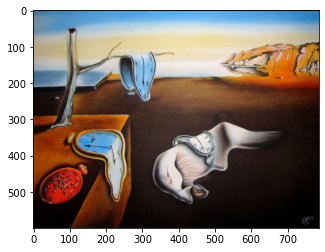

In [93]:
imShow(dataColor)

In [46]:
dataGrey = rgbToGrey(dataColor)

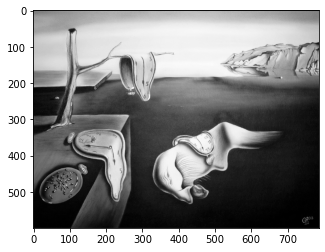

In [47]:
imShow1(dataGrey)

In [94]:
edge = getEdge(dataGrey)

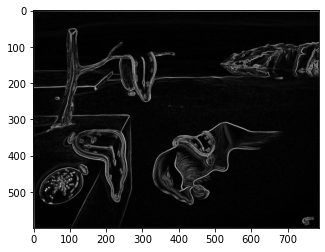

In [97]:
imShow2(edge)

In [103]:
cost = findCostArr(edge)

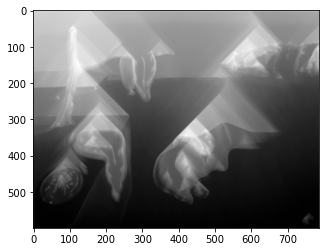

In [106]:
imShow1(cost1)

In [20]:
seam = findSeam(cost)
mark = markSeam(dataColor,seam)

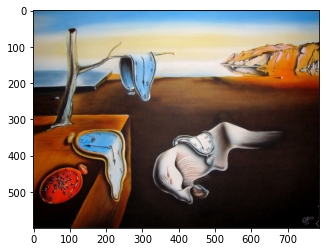

In [21]:
imShow(mark)

In [22]:
smImg = removeSeam(dataColor,seam)

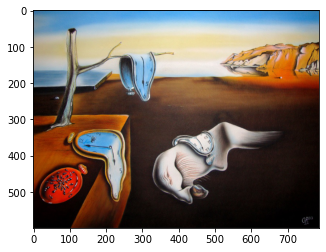

In [23]:
imShow(smImg)

In [108]:
# pre calculate the display images

markImages = [dataColor]

for i in range(1,101):
    
    dataGrey = rgbToGrey(dataColor)
    edge = getEdge(dataGrey)
    cost = findCostArr(edge)
    seam = findSeam(cost)
    mark = markSeam(dataColor,seam)
    
    markImages.append(mark)
    dataColor = removeSeam(dataColor,seam)

<IPython.core.display.Javascript object>


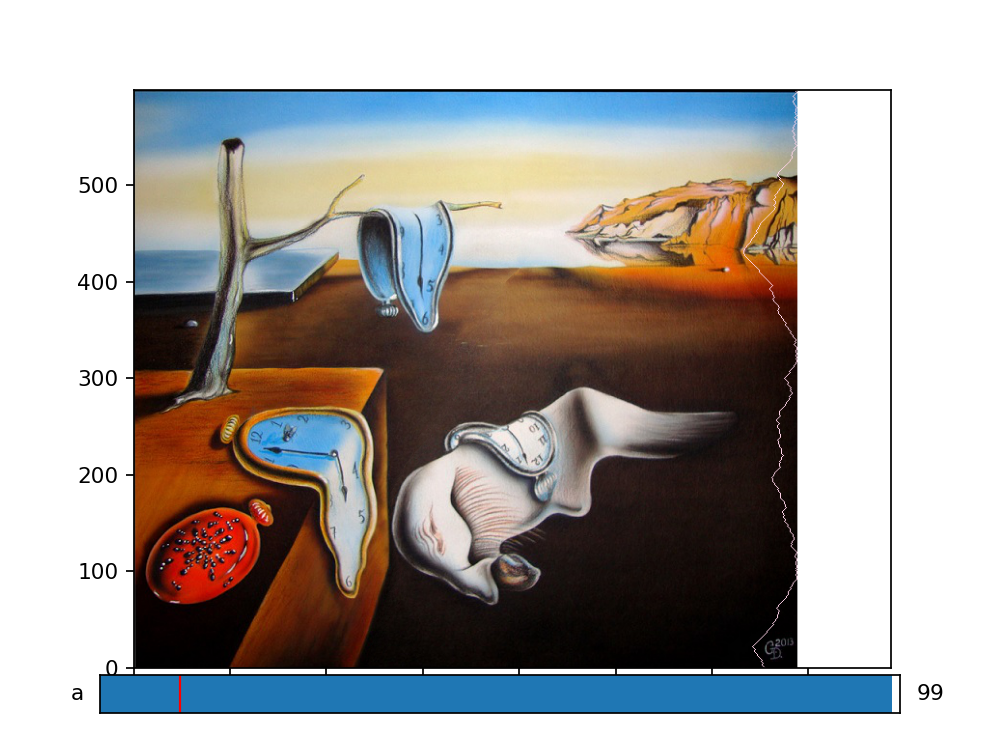

0

In [109]:
from matplotlib.widgets import Slider  
%matplotlib notebook

fig = plt.figure()

ax2 = fig.add_subplot(1, 1, 1)
imPlot = ax2.imshow(np.flip(markImages[0],0).astype(np.int32), aspect='equal')
ax2.set_xlim(0,markImages[0].shape[1])
ax2.set_ylim(0,markImages[0].shape[0])

def update(a):
    
    i = int(a)
    imgArr = markImages[i]
    r = markImages[0].shape[0]
    if i!=0:
        imgArr = np.concatenate((imgArr,np.zeros((r,i-1,3))+255),axis=1)
    
    imPlot.set_data(np.flip(imgArr,0).astype(np.int32))
    fig.canvas.draw_idle()

slider_ax = plt.axes([0.1, 0.05, 0.8, 0.05])
a_slider = Slider(slider_ax,'a',0,len(markImages)-1,valinit=10,valstep = 1)
a_slider.on_changed(update)